#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, pdist
from tqdm import tqdm
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [23]:
pd.set_option("display.max_columns", 500)

# 2. Grouping songs together!

### 2.1. Getting your data!

First of all, let's load the three different datasets and have a look at each of them to see what we are working with. We will also look at some basic information:
- shape (number of rows and columns)
- name of the columns

In [2]:
tracks = pd.read_csv('tracks.csv')
features = pd.read_csv('features.csv')
echonest = pd.read_csv('echonest.csv')

##### 1) 'tracks.csv'

In [24]:
tracks.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [ ]:
tracks.shape

(106574, 53)

In [23]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

##### 2) 'features.csv'

In [25]:
features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma

In [24]:
features.shape

(106574, 519)

In [25]:
features.columns

Index(['track_id', 'chroma_cens_kurtosis_01', 'chroma_cens_kurtosis_02',
       'chroma_cens_kurtosis_03', 'chroma_cens_kurtosis_04',
       'chroma_cens_kurtosis_05', 'chroma_cens_kurtosis_06',
       'chroma_cens_kurtosis_07', 'chroma_cens_kurtosis_08',
       'chroma_cens_kurtosis_09',
       ...
       'tonnetz_std_04', 'tonnetz_std_05', 'tonnetz_std_06', 'zcr_kurtosis_01',
       'zcr_max_01', 'zcr_mean_01', 'zcr_median_01', 'zcr_min_01',
       'zcr_skew_01', 'zcr_std_01'],
      dtype='object', length=519)

##### 3) 'echonest.csv'

In [26]:
echonest.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

In [9]:
echonest.shape

(13129, 250)

In [11]:
echonest.columns

Index(['track_id', 'audio_features_acousticness',
       'audio_features_danceability', 'audio_features_energy',
       'audio_features_instrumentalness', 'audio_features_liveness',
       'audio_features_speechiness', 'audio_features_tempo',
       'audio_features_valence', 'metadata_album_date',
       ...
       'temporal_features_214', 'temporal_features_215',
       'temporal_features_216', 'temporal_features_217',
       'temporal_features_218', 'temporal_features_219',
       'temporal_features_220', 'temporal_features_221',
       'temporal_features_222', 'temporal_features_223'],
      dtype='object', length=250)

##### Merging

The datasets vary in shape and column names, but we see that all three of them share a column with the same name: the 'track_id' column, which seems to associate each track to a specific integer.
<br>
To merge the three datasets together, we will keep only the tracks that are in the 'echonest.csv' file, since this is the dataset with the smallest number of rows (13129 vs 106574 of the other two datasets). If we were to keep all the tracks in the other two datasets, a huge number of them would have missing values for the columns featured in the 'echonest' dataset. By doing this instead, we'd expect to have a dataset that is as complete as possible.
<br>
The reasonable choice, then, is to merge the datasets along the 'track_id' column, which is therefore being identified as the key to read different information accross the dataset for the same track. We will do this in two steps:
- first, we merge 'echonest.csv' with 'tracks.csv'
- then we merge the resulting dataset with 'features.csv'.

To check if the datasets merged in the way we wanted, we shall check their shape: the final dataset should have the same number of rows of 'echonest.csv' and a number of columns equal to the sum of all three datasets -2 (since we are not counting the 'track_id' column from 'tracks.csv' and 'features.csv').

In [221]:
step1 = echonest.merge(tracks, on = 'track_id')

In [222]:
merged = step1.merge(features, on = 'track_id')

In [223]:
merged

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

In [6]:
n_cols = (echonest.shape[1] + tracks.shape[1] + features.shape[1]) - 2
n_rows = echonest.shape[0]
print(f"The desired shape is: ({n_rows}, {n_cols}).")
print(f"The actual shape is: {merged.shape}.")

The desired shape is: (13129, 820).
The actual shape is: (13129, 820).


### 2.2. Choose your features!

First of all, let's have a look at the data types we are dealing with.

In [105]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 820 entries, track_id to zcr_std_01
dtypes: float64(764), int64(16), object(40)
memory usage: 82.2+ MB


As we see, the majority of our data consists of numeric values (floats and integers), while a small part is given by strings or mixed data types. Given the huge importance of numeric values over categorical ones, to achieve the dimensionality reduction we will perform <b>Principal Component Analysis</b> on these features.
Still, some of the categorical values will also have an importance later, so we will choose the most relevant variables between them and stack them with the reduced dataset resulting of the PCA procedure. In order to keep things tidier, we are also going to drop columns that contain missing values.
Before performing the dimensinality reduction, we need to normalize our data. By looking at the column names coming from 'tracks.csv', we have found three variables that we don't want to scale, as they give us precise information on how to identify the track and the corresponding album and artist. As we are going to do with relevant categorical variables, we are going to set these columns aside and add them back later on, once the dimensionality reduction process is over.

In [7]:
# keeping only columns with numeric values
only_num = merged.select_dtypes(include=np.number)
# dropping NaN values
only_num = only_num.dropna(axis = 1, how='any')
# dropping columns we don't want to scale
to_drop = ['track_id', 'album_id', 'artist_id']
only_num = only_num.drop(to_drop, axis=1)
# have a look 
only_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Columns: 768 entries, audio_features_acousticness to zcr_std_01
dtypes: float64(755), int64(13)
memory usage: 77.0 MB


In [8]:
# initialize scaler
scaler = StandardScaler()
# scale and restore processed data in a dataframe with the same columns
scaled_data = scaler.fit_transform(only_num.values)
scaled_df = pd.DataFrame(scaled_data, columns = only_num.columns)
scaled_df.head()

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,-0.281499,0.991915,0.348732,-1.742887,-0.064267,0.437749,1.223573,0.495983,0.584512,0.782963,...,-1.310092,-1.564443,-1.654377,-0.381721,0.393540,1.208676,1.035766,-0.594301,-0.378710,0.932033
1,-0.391656,0.217484,1.006860,-1.767172,-0.518358,2.639805,0.110726,-0.617788,0.584512,0.782963,...,-1.021250,-1.202410,-0.608422,-0.439876,0.432798,1.168234,0.742018,-0.594301,-0.526657,1.267315
2,-1.253885,1.358338,0.589683,-1.770366,1.172705,0.185049,-0.651745,0.659017,0.584512,0.782963,...,-1.708717,-1.479675,-1.162289,-0.360920,-0.091584,-0.042573,-0.158812,-0.594301,-0.337701,0.226443
3,1.112791,0.898745,1.391929,0.898939,-0.457654,-0.481812,-0.328958,1.897809,2.053342,2.556413,...,-0.707981,-0.520648,-1.317931,-0.071044,0.351477,0.896399,1.055350,-0.594301,0.197164,0.053735
4,-0.188870,0.136465,0.082343,-1.718498,-0.577286,3.103507,-0.251046,1.645950,0.584512,0.782963,...,-1.171979,-0.817691,-0.965264,-0.402092,0.163596,0.390558,0.213270,-0.594301,-0.491219,0.641704


In [9]:
# performing PCA
pca = PCA(n_components=70)
components = pca.fit_transform(scaled_df.values)
PCA_df = pd.DataFrame(data = components, columns = [x for x in range(1,71)])
PCA_df.head()

,1,2,3,4,5,6,7,8,9,10,...,61,62,63,64,65,66,67,68,69,70
0,3.073380,-2.813784,-5.723231,4.298900,3.143576,2.044949,6.773870,-0.910137,-2.228266,4.279328,...,2.071395,1.027920,0.447497,-0.082853,-0.595676,0.195209,-0.314357,0.323305,-2.211705,-0.884260
1,5.774619,-5.410043,-5.293710,-1.575243,-3.638760,2.656023,-1.533235,5.904929,-0.147311,4.190937,...,0.346734,-0.593198,0.935102,-0.556996,-1.378429,0.093884,-0.486242,-0.348202,-0.448445,0.278594
2,2.651468,-4.167767,-4.566703,-0.037030,-2.853624,2.101070,-1.273032,-0.324173,-0.105284,1.758415,...,0.854042,-1.023633,0.904589,-1.882714,1.216646,0.392019,-0.322702,0.840604,-1.117267,0.242901
3,9.102106,3.791647,-5.511918,0.780154,-1.354686,0.609045,-1.804491,4.104999,-0.539536,4.886375,...,1.771581,0.473013,-0.095864,-0.426155,-2.919659,1.774542,3.764638,0.566888,0.519878,0.553198
4,1.307770,-9.453891,-4.280977,0.735417,-3.824223,-1.230764,-2.935264,-2.200753,-0.516419,2.519043,...,1.442872,-2.907118,2.780292,-0.749012,-0.234187,-0.077802,-1.265032,0.353076,-1.454269,-0.162607


Let's check the percentage of retained variance after the dimensionality reduction and plot it against the number of components of our model to check the impact of adding more components to our results.

In [10]:
retained_variance = round(sum(pca.explained_variance_ratio_),2)*100
print(f"{retained_variance} % of the total variance was retained after the dimensionality reduction.")

71.0 % of the total variance was retained after the dimensionality reduction.


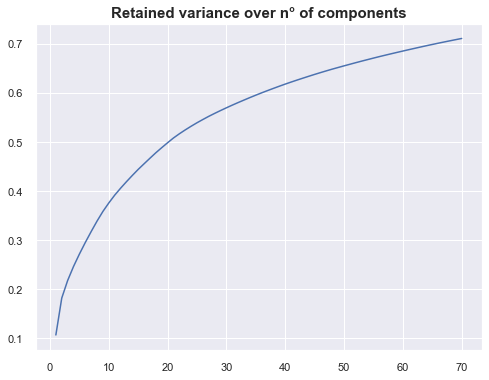

In [11]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.lineplot(x=PCA_df.columns,
                 y=np.cumsum(pca.explained_variance_ratio_))
_ = plt.title('Retained variance over n° of components',fontweight="bold", fontsize=15)

### 2.3. Clustering!

Let's define our own version of the K-Means algorithm from scratch:

In [12]:
def kmeans(data, k, max_iters):
    # initializing random centroids
    start = np.random.choice(len(data), k, replace=False)
    centroids = data.iloc[start, :]
    # computing all euclidean distances between data points
    dist = cdist(data, centroids ,'euclidean')
     
    # finding the closest centroid for each data point
    clusters = []
    for d in dist:
        clusters.append(np.argmin(d))
    clusters = np.array(clusters)
    # repeating until convergence
    for it in range(max_iters): 
        centroids = []
        for j in range(k):
            # redefining centroids of each cluster
            jth_cluster = clusters == j
            temp = data[jth_cluster].mean(axis=0) 
            centroids.append(temp)
        
        centroids = np.vstack(centroids)
        # reassigning data points to closest centroid
        dist = cdist(data, centroids ,'euclidean')
        clusters = []
        for d in dist:
            clusters.append(np.argmin(d))
        clusters = np.array(clusters)
        
    return clusters, centroids

To find the optimal number of clusters, we are going to use the Elbow Method to evaluate the number of clusters where the value of the average Within Clusters Sums of Squares stabilizes around a certain minimum value, and the Gap Statistics Method, that confronts the distribution of our data to a random samples of data references that are uniformly generated. (The main reference for the implementation of this last method is <a href="https://web.stanford.edu/~hastie/Papers/gap.pdf">this</a> paper.) For the Gap Statistics Method, the optimal value of clusters corresponds to the value of k that maximises the Gap Statistics.

In [13]:
def elbow(data):
    squared_distances = []
    for k in tqdm(range(1,16)):
        # creating k clusters for each iteration
        clusters, centroids = kmeans(data, k, 1000)
        for j in range(k):
            distances = []
            # computing distances between centroids and each cluster
            jth_cluster = data[clusters == j]
            temp = sum(cdist(jth_cluster, centroids, 'euclidean'))
            distances.append(sum(temp)/len(temp))
        # averaging distances
        squared_distances.append(sum(distances)/k)
    # plotting average distance for each value of k
    plt.plot([x for x in range(1,16)], squared_distances)
    plt.title('Elbow Method', fontweight='bold', fontsize=15)
    plt.ylabel('Average WCSS')
    plt.xlabel('Number of clusters')

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [13:43<00:00, 54.90s/it]


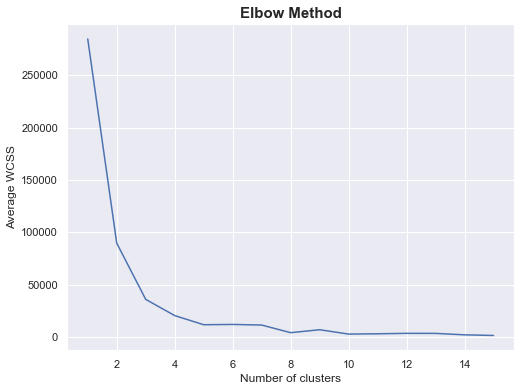

In [117]:
elbow(PCA_df)

In [14]:
def generate_references(B, data, i):
    ''' Function to generate B random samples, for each one compute the sum of all paired distances between data points,
    and store them in an array.'''
    w_k_b = []
    for j in range(i):
        for b in range(B):
            rs_ref = 0
            # generate random sample that has the same shape of our data
            ref = np.random.random_sample(size=(data.shape))
            ref = pd.DataFrame(ref)
            # clustering the reference sample
            clusters_ref = kmeans(ref, i, 100)[0]
            cluster_ref = ref[clusters_ref == j]
            # computing sum of pairwise distances
            dist_ref = sum(pdist(cluster_ref, 'euclidean'))
            # normalizing
            rs_ref += (1/2*len(cluster_ref)*dist_ref)
            # storing result of the sample
            w_k_b.append(rs_ref)
    return np.array(w_k_b)

In [15]:
def gap(data):
    res = []
    for i in tqdm(range(1,16)):
        # creating clusters for our data and generating the reference random samples
        clusters= kmeans(data, i, 100)[0]
        w_k_b = generate_references(10, data, i)
        for j in range(i):
            # computing sum of pairwise distances for our clusters
            cluster = data[clusters == j]
            rs = 0
            dist = sum(pdist(cluster, 'euclidean'))
            # normalizing
            rs += (1/2*len(cluster)*dist)
        # computing the expected value of the random samples 
        exp_value = np.mean(np.log(w_k_b))
        # computing gap statistics
        gap = exp_value - np.log(rs)
        res.append(gap)
    # plotting gap statistics for each number of clusters
    plt.plot([x for x in range(1,16)], res)
    plt.title('Gap Statistics Method', fontweight='bold', fontsize=15)
    plt.ylabel('Gap')
    plt.xlabel('Number of clusters')
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [2:01:47<00:00, 487.18s/it]


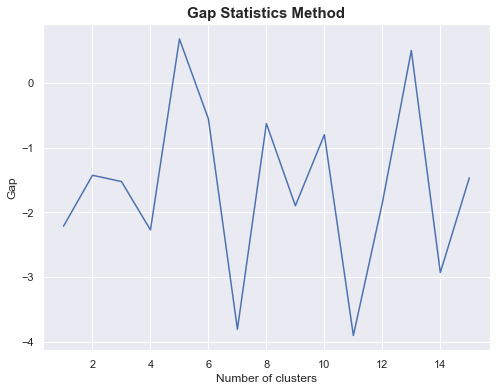

In [17]:
gap(PCA_df)

As we can see by looking at the generated plots, our Elbow and our Gap Statistics plots both suggest an optimal number of clusters equal to 5, even though it's important to point out that we notice a certain variability in the Gap Statistics values, which is partially due to the randmoness induced in the reference samples.
Let's then divide our data into 5 clusters, then do the same but using the K-Means++ algorithm implemented in the SciKit Learn library, and compare our results.

In [206]:
clusters = kmeans(PCA_df, 5, 1000)[0]

In [17]:
model = KMeans(n_clusters = 5)
model.fit(PCA_df)
cluster_sk = model.predict(PCA_df)

In [21]:
# Adding the columns of cluster assignments to our dataframe
PCA_df['our_clusters'] = 0
PCA_df['our_clusters'] = clusters
PCA_df['sk_clusters'] = 0
PCA_df['sk_clusters'] = cluster_sk

In [22]:
clust_perc = (PCA_df['our_clusters'].value_counts() / 13129).sort_values(ignore_index = True)
clust_perc_sk = (PCA_df['sk_clusters'].value_counts() / 13129).sort_values(ignore_index = True)
pd.DataFrame([clust_perc, clust_perc_sk])

,0,1,2,3,4
our_clusters,0.072359,0.159799,0.203138,0.236652,0.328052
sk_clusters,0.073197,0.159494,0.202453,0.236042,0.328814


As we can see, the clusters we have created have roughly the same sizes as the ones resulting from the KMeans++ algorithm.

### 2.4. Analysing your results!

To perform our final analysis, let's go back to the dataset we were working with before the dimensionality reduction and add the column of the assigned clusters for each song. For convenience, we will also add a column called 'counts' which contains all ones. We are going to define a function 'pivot' in order to easily create the pivot table for each variable we're interested in.

In [224]:
merged['clusters'] = 0
merged['clusters'] = clusters + 1
merged['counts'] = 1

In [208]:
def pivot(data, column):
    # Extracting relevant columns
    df = data[[column, 'clusters', 'counts']]
    # Creating pivot table
    pivot = pd.pivot_table(df, index = column, columns = 'clusters', aggfunc = sum, fill_value = 0)
    # Calculating percentages
    for i in range(5):
        tot = sum(pivot[pivot.columns[i]].values)
        pivot.iloc[:, i] = round(pivot.iloc[:, i] / tot * 100, 2)
    # Adding columns totals
    pivot.loc['Total'] = round(pivot.sum(),0)
    return pivot

##### #1: Song language

Let's have a look at the different languages of our songs in our clusters.

In [220]:
pivot(merged, 'track_language_code')

counts                                
clusters                 1       2       3       4       5
track_language_code                                       
ar                     0.0    0.08    0.00    0.00    0.34
bm                     0.0    0.00    0.00    0.00    0.09
cs                     0.0    0.00    0.05    0.10    0.00
de                     0.0    0.00    0.16    0.00    0.09
el                     0.0    0.00    0.05    0.41    0.00
en                    99.8   93.80   95.55   96.60   96.22
es                     0.2    3.37    2.10    1.75    1.03
fi                     0.0    0.00    0.00    0.00    0.26
fr                     0.0    1.25    0.05    0.00    0.34
it                     0.0    0.24    0.21    0.10    0.43
ja                     0.0    0.24    0.00    0.00    0.00
ko                     0.0    0.00    0.00    0.10    0.00
pt                     0.0    0.94    0.31    0.10    0.60
ru                     0.0    0.08    0.42    0.21    0.00
sr                     0.0    0.00    0.21    0.21    0.00
sw                     0.0    0.00    0.16    0.00    0.17
tr                     0.0    0.00    0.68    0.31    0.43
zh                     0.0    0.00    0.05    0.10    0.00
Total                100.0  100.00  100.00  100.00  100.00

Not surprisingly, English is the most popular language across all clusters. What we can point out is that cluster 2 seems to be the most international one (with higher percentages of Spanish and French songs), while in cluster 1 we only find two languages: prevalently English, and a little bit of Spanish.

##### #2: Song duration

In [225]:
# Have a look at the range of values to make categories
print(merged['track_duration'].min(), merged['track_duration'].max())

18 3033


Let's divide the variable into four categories:
- short, for songs shorter than 60 seconds
- medium, for songs between 1 and 5 minutes
- long, for songs between 5 and 8 minutes
- very long, for songs longer than 8 minutes

In [226]:
merged['track_duration'] = merged['track_duration'].apply(pd.to_numeric)
for i in range(len(merged)):
    if merged['track_duration'].iloc[i] < 60:
        merged['track_duration'].iloc[i] = 'Short'
    elif 60 <= merged['track_duration'].iloc[i] < 300:
        merged['track_duration'].iloc[i] = 'Medium'
    elif 300 <= merged['track_duration'].iloc[i] < 480:
        merged['track_duration'].iloc[i] = 'Long'
    elif merged['track_duration'].iloc[i] >= 480:
        merged['track_duration'].iloc[i] = 'Very long'

In [227]:
pivot(merged, 'track_duration')

counts                                
clusters             1       2       3       4       5
track_duration                                        
Long              7.59   20.35   15.50    9.28   21.62
Medium           86.31   71.76   79.85   84.69   67.87
Short             2.25    1.95    1.30    4.32    1.06
Very long         3.85    5.94    3.35    1.72    9.45
Total           100.00  100.00  100.00  100.00  100.00

Song durations tend to be on average in the 'medium' section, but clusters 2 and 5 have a pretty remarkable percentage of 'long' and 'very long' songs, while cluster 4 is the one with the highest percentage of 'short' songs.

##### #3: Acousticness

The acousticness score should be a measure of the presence of acoustic instruments in a given song.
The four categories are:
- not acoustic ( $< 0.25$ )
- somewhat acoustic ( $[0.25, 0.5)$ )
- acoustic ( $[0.5, 0.75)$ )
- extremely acoustic ( $>0.75$ )

In [228]:
print(merged['audio_features_acousticness'].min(), merged['audio_features_acousticness'].max())

9.035e-07 0.9957964501


In [229]:
for i in range(len(merged)):
    if merged['audio_features_acousticness'].iloc[i] < 0.25:
        merged['audio_features_acousticness'].iloc[i] = 'Not acoustic'
    elif 0.25 <= merged['audio_features_acousticness'].iloc[i] < 0.5:
        merged['audio_features_acousticness'].iloc[i] = 'Somewhat acoustic'
    elif 0.5 <= merged['audio_features_acousticness'].iloc[i] < 0.75:
        merged['audio_features_acousticness'].iloc[i] = 'Acoustic'
    elif merged['audio_features_acousticness'].iloc[i] >= 0.75:
        merged['audio_features_acousticness'].iloc[i] = 'Extremely acoustic'

In [230]:
pivot(merged, 'audio_features_acousticness')

counts                                
clusters                          1       2       3       4       5
audio_features_acousticness                                        
Acoustic                       0.64   13.31   16.27   13.23   12.48
Extremely acoustic            98.61   15.55   32.35   30.26   70.18
Not acoustic                   0.53   53.75   37.25   44.41   10.02
Somewhat acoustic              0.21   17.40   14.14   12.11    7.32
Total                        100.00  100.00  100.00  100.00  100.00

Cluster 1 has a significant prevalence of songs that mainly feature acoustic instruments, while songs in cluster 2 are mostly non-acoustic. Cluster 4 and 5 are also skewed towards more acoustic features, and cluster 3 is pretty well balanced, with a slight prevalence of less acoustic songs.

##### #4: Danceability

The four categories are:
- not danceable ( $< 0.25$ )
- somewhat danceable ( $[0.25, 0.5)$ )
- danceable ( $[0.5, 0.75)$ )
- extremely danceable ( $>0.75$ )

In [231]:
print(merged['audio_features_danceability'].min(), merged['audio_features_danceability'].max())

0.051307487 0.9686446617


In [232]:
for i in range(len(merged)):
    if merged['audio_features_danceability'].iloc[i] < 0.25:
        merged['audio_features_danceability'].iloc[i] = 'Not danceable'
    elif 0.25 <= merged['audio_features_danceability'].iloc[i] < 0.5:
        merged['audio_features_danceability'].iloc[i] = 'Somewhat danceable'
    elif 0.5 <= merged['audio_features_danceability'].iloc[i] < 0.75:
        merged['audio_features_danceability'].iloc[i] = 'Danceable'
    elif merged['audio_features_danceability'].iloc[i] >= 0.75:
        merged['audio_features_danceability'].iloc[i] = 'Extremely danceable'

In [233]:
pivot(merged, 'audio_features_danceability')

counts                                
clusters                          1       2       3       4       5
audio_features_danceability                                        
Danceable                     22.57   52.58   38.36   20.46   39.23
Extremely danceable            0.96   29.24    3.45    3.90    4.48
Not danceable                 18.93    1.14   11.36   26.77   11.19
Somewhat danceable            57.54   17.04   46.83   48.86   45.11
Total                        100.00  100.00  100.00  100.00  100.00

The songs featured in cluster 2 are definitely the most danceable, which goes in accordance with their mostly non-acoustic nature, as we saw in the previous step. On the other side, clusters 1 and 4 are the ones that feature the highest percentages of non-danceable songs.

##### #5: Energy

This score should represent a measure of how overal frenetic a song is.
The four categories are:
- calm ( $< 0.25$ )
- somewhat energic ( $[0.25, 0.5)$ )
- energic ( $[0.5, 0.75)$ )
- extremely energic ( $>0.75$ )

In [234]:
print(merged['audio_features_energy'].min(), merged['audio_features_energy'].max())

2.01659e-05 0.9999637108


In [235]:
for i in range(len(merged)):
    if merged['audio_features_energy'].iloc[i] < 0.25:
        merged['audio_features_energy'].iloc[i] = 'Calm'
    elif 0.25 <= merged['audio_features_energy'].iloc[i] < 0.5:
        merged['audio_features_energy'].iloc[i] = 'Somewhat energic'
    elif 0.5 <= merged['audio_features_energy'].iloc[i] < 0.75:
        merged['audio_features_energy'].iloc[i] = 'Energic'
    elif merged['audio_features_energy'].iloc[i] >= 0.75:
        merged['audio_features_energy'].iloc[i] = 'Extremely energic'

In [236]:
pivot(merged, 'audio_features_energy')

counts                                
clusters                    1       2       3       4       5
audio_features_energy                                        
Calm                    78.93    6.49    3.52    3.62   49.47
Energic                  2.67   38.53   41.55   22.65    9.56
Extremely energic        0.43   26.94   30.43   66.22    1.40
Somewhat energic        17.97   28.04   24.50    7.52   39.57
Total                  100.00  100.00  100.00  100.00  100.00

Cluster 1 is clearly the calmest ones, followed by cluster 5. Cluster 2 and 3 are overall pretty energic, but cluster 4 is obviously the one with the highest concentration of frenetic activity. At the same time, in the previous steps we discovered that songs in cluster 4 are not that danceable: maybe some kind of heavy rock/metal...?

##### #6: Speechiness

Speechiness refers to the presence of spoken words versus sung and melodic parts in the song.
The four categories are (notice that the intervals are not symmetric to account for the way the variable is actually distributed across all songs):
- mostly sung ( $< 0.1$ )
- some spoken words ( $[0.1, 0.45)$ )
- mostly spoken words ( $[0.45, 0.7)$ )
- almost only spoken words ( $>0.7$ )

In [237]:
print(merged['audio_features_speechiness'].min(), merged['audio_features_speechiness'].max())

0.0223236675 0.9661774074


In [238]:
for i in range(len(merged)):
    if merged['audio_features_speechiness'].iloc[i] < 0.1:
        merged['audio_features_speechiness'].iloc[i] = 'Mostly sung'
    elif 0.1 <= merged['audio_features_speechiness'].iloc[i] < 0.45:
        merged['audio_features_speechiness'].iloc[i] = 'Some spoken words'
    elif 0.45 <= merged['audio_features_speechiness'].iloc[i] < 0.7:
        merged['audio_features_speechiness'].iloc[i] = 'Mostly spoken words'
    elif merged['audio_features_speechiness'].iloc[i] >= 0.7:
        merged['audio_features_speechiness'].iloc[i] = 'Almost only spoken words'

In [239]:
pivot(merged, 'audio_features_speechiness')

counts                                
clusters                         1       2       3       4       5
audio_features_speechiness                                        
Almost only spoken words      2.25    3.96    0.14    0.42    0.38
Mostly spoken words           2.14    7.69    0.65    1.07    0.87
Mostly sung                  83.96   50.34   88.89   81.35   91.46
Some spoken words            11.66   38.01   10.32   17.17    7.28
Total                       100.00  100.00  100.00  100.00  100.00

The highest concentration of songs that have a somewhat significant presence of spoken words in them can be found in cluster 2. In general, the other clusters prevalently feature more melodic songs, with cluster 5 being the one where songs have the least spoken words in them.

##### #7: Valence

Valence tries to measure the positiveness (happiness, cheerfulness, playfulness, etc.) of a song. Lower scores means that a song has more negative vibes (sadness, malincholia, nostalgia, etc.).
The four categories are (also here we're trying to balance out the way the score is distributed by adjusting the intervals):
- really sad ( $< 0.1$ )
- not so cheerful ( $[0.1, 0.45)$ )
- in a nice mood ( $[0.45, 0.7)$ )
- euphoric ( $>0.7$ )

In [240]:
print(merged['audio_features_valence'].min(), merged['audio_features_valence'].max())

1e-05 0.99999


In [241]:
for i in range(len(merged)):
    if merged['audio_features_valence'].iloc[i] < 0.1:
        merged['audio_features_valence'].iloc[i] = 'Really sad'
    elif 0.1 <= merged['audio_features_valence'].iloc[i] < 0.4:
        merged['audio_features_valence'].iloc[i] = 'Not so cheerful'
    elif 0.4 <= merged['audio_features_valence'].iloc[i] < 0.65:
        merged['audio_features_valence'].iloc[i] = 'In a nice mood'
    elif merged['audio_features_valence'].iloc[i] >= 0.65:
        merged['audio_features_valence'].iloc[i] = 'Euphoric'

In [242]:
pivot(merged, 'audio_features_valence')

counts                                
clusters                     1       2       3       4       5
audio_features_valence                                        
Euphoric                 23.21   35.67   31.42   24.04   11.46
In a nice mood           21.28   30.19   28.25   23.85   18.25
Not so cheerful          38.18   26.36   32.95   35.45   46.78
Really sad               17.33    7.79    7.38   16.66   23.52
Total                   100.00  100.00  100.00  100.00  100.00

Clusters 2 and 3 are the ones were songs are generally associated with more positive vibes, while cluster 1 and 5 have a higher concentration of gloomier songs. Cluster 4 is pretty balanced out.

##### #8: Tempo

The four categories are:
- pretty slow ( $< 80$ )
- medium fast ( $[80, 110)$ )
- pretty fast ( $[110, 200)$ )
- ...too fast? ( $>200$ )

In [243]:
print(merged['audio_features_tempo'].min(), merged['audio_features_tempo'].max())

12.753 251.072


In [244]:
for i in range(len(merged)):
    if merged['audio_features_tempo'].iloc[i] < 80:
        merged['audio_features_tempo'].iloc[i] = 'Pretty slow'
    elif 80 <= merged['audio_features_tempo'].iloc[i] < 120:
        merged['audio_features_tempo'].iloc[i] = 'Medium fast'
    elif 120 <= merged['audio_features_tempo'].iloc[i] < 200:
        merged['audio_features_tempo'].iloc[i] = 'Pretty fast'
    elif merged['audio_features_tempo'].iloc[i] >= 200:
        merged['audio_features_tempo'].iloc[i] = 'Too fast?'

In [245]:
pivot(merged, 'audio_features_tempo')

counts                                
clusters                   1       2       3       4       5
audio_features_tempo                                        
Medium fast            43.85   42.94   36.97   35.73   44.92
Pretty fast            34.97   47.78   55.90   56.43   37.78
Pretty slow            19.14    6.52    5.28    4.55   15.36
Too fast?               2.03    2.76    1.85    3.29    1.93
Total                 100.00  100.00  100.00  100.00  100.00

The highest concentrations of slower songs can be found in clusters 1 and 5, which is not surprising if we consider that in the previous step we found out that they also were the 'sadder' clusters. In general, songs tend to be averagely fast (it might have been interesting to have more categories to account for smaller variations in tempo). Cluster 4 is the one with the highest percentage of faster songs.

##### #9: Artist hotness score

This score should try to account for the performance of the corresponding artist (in charts, for example) as a proxy for the popularity of the song itself.
The four categories are:
- freezing cold ( $< 0.15$ )
- warm ( $[0.15, 0.3)$ )
- pretty hot ( $[0.3, 0.5)$ )
- boiling hot( $>0.5$ )
<br>

Remark: the 'song hotness' score might have given a better feeling of the actual performance of the song, but this feature had a pretty high presence of zero values.

In [154]:
print(merged['social_features_artist_hotttnesss'].min(), merged['social_features_artist_hotttnesss'].max())

0.0 0.808122


In [246]:
for i in range(len(merged)):
    if merged['social_features_artist_hotttnesss'].iloc[i] < 0.15:
        merged['social_features_artist_hotttnesss'].iloc[i] = 'Freezing cold'
    elif 0.15 <= merged['social_features_artist_hotttnesss'].iloc[i] < 0.3:
        merged['social_features_artist_hotttnesss'].iloc[i] = 'Warm'
    elif 0.3 <= merged['social_features_artist_hotttnesss'].iloc[i] < 0.5:
        merged['social_features_artist_hotttnesss'].iloc[i] = 'Pretty hot'
    elif merged['social_features_artist_hotttnesss'].iloc[i] >= 0.5:
        merged['social_features_artist_hotttnesss'].iloc[i] = 'Boiling hot'

In [247]:
pivot(merged, 'social_features_artist_hotttnesss')

counts                                
clusters                                1       2       3       4       5
social_features_artist_hotttnesss                                        
Boiling hot                          6.84    9.12   15.18   13.27   11.91
Freezing cold                       15.83   10.29    6.52    7.75    9.86
Pretty hot                          48.98   47.97   54.42   51.69   49.54
Warm                                28.34   32.62   23.88   27.29   28.68
Total                              100.00  100.00  100.00  100.00  100.00

The performance seems to be pretty good across all clusters, but we can see that cluster 1 and 2 are the ones where we can find a higher concentration of songs made by not particularly appreciated artists. Cluster 3 and 4, on the other hand, seem to be the ones that feature the highest percentages of popular artists.

#### Compare with true genres

In [248]:
pivot(merged, 'track_genre_top')

counts                                
clusters                  1       2       3       4       5
track_genre_top                                            
Blues                  0.28    0.34    0.64    0.00    2.14
Classical             22.50    0.15    0.29    0.17    5.09
Electronic             6.39   54.28   13.35   17.31   16.90
Experimental           0.28    0.10    0.16    0.17    0.29
Folk                  14.03    1.07    6.98    2.52   28.36
Hip-Hop                0.14   28.48    6.24    5.27    2.20
Instrumental           0.83    0.49    0.93    0.46    1.79
International          0.83    0.78    1.61    0.97    2.55
Jazz                   2.50    1.22    1.58    1.09    7.52
Old-Time / Historic   47.78    0.05    0.16    0.17    0.23
Pop                    0.83    2.97    3.83    2.29    6.94
Rock                   3.61   10.08   64.22   69.57   25.98
Total                100.00  100.00  100.00  100.00  100.00

### 3. Algorithmic Question

In [21]:
def paired_sum(a, s):
    pairs = []
    for i, el in enumerate(a):
        for j in range(i+1, len(a)):
            if el + a[j] == s and (el, a[j]) not in pairs:
                pairs.append((el, a[j]))
    return pairs

Let's try it out:

In [22]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 2, 1, 3, -3]
s = 4
paired_sum(A,s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]